# DATASCI W261, Machine Learning at Scale
--------
#### Assignement:  week \#5
#### Shih Yu Chang
### Due: 2016-10-04, 8AM PST

## HW 5.0
- What is a data warehouse? What is a Star schema? When is it used?


## HW 5.1
- In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 
- In what form does ML consume data?
- Why would one use log files that are denormalized?


**Answers for 5.0**:
1. A data warehouse is a data repository of all relevant information, ranging from relational databases (such as business transaction data) to semi-structured data files (such as logs) used for business intelligence and data science. Traditionally, data warehouses process with high volume and high variety, but they are fed by various data pipelines in batch processes in order to support online analytics processing (OLAP).

2. A star schema is a schema that relates a large table (the star schema) with multiple dimension tables (tables that contain the actual information).  A fact table typically has two types of columns: foreign keys to dimension tables and measures those that contain numeric facts and it can contain fact's data on detail or aggregated level. A dimension table is a structure usually composed of one or more hierarchies that categorizes data. This relationship between fact tables and information schemas is depicted in [http://datawarehouse4u.info/Data-warehouse-schema-architecture-star-schema.html].

3. A star schema is used to organize the metadata of a relational database and facilitate joins of tables by providing information on which tables can be joined with their keys. They are applied when a query joining multiple tables must be materialized. Their design and application makes them similar to snowflake schemas, but star schemas are denormalized whereas snowflake schemas are normalized.

**Answers for 5.1**:
1. In Codd's hierarchy of normal forms, third normal form is a reduction of non-key column redundancy with and across rows, but not within superkeys. This avoidance of functional dependencies is (almost) sufficient to guarantee referential integrity during modification 
2. ML algorithms do not generally use normalized data, In other words, ML may consume data that is in 3NF but it also consumes data on denormalized views resulting from joins of 3NF normalized tables or even data that is not normalized at all. However, since features space is various, the easiest way for ML to ingest data in a parallel method is data denormalized.
3. ML algorithms generally use highly denormalized data transformed into a suitable feature space.
4. If log files are not normalized, the various pieces of a record would need to be located and processed in order (joined) to process each record

## HW 5.2, Using MRJob, implement a hashside join (memory-backed map-side) for left, right, and inner join

In [70]:
%%writefile HW5_2_JoinTable.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class JoinTable(MRJob):
    
    def mapper_init(self):
        self.left = {}
        self.right = []
        self.vistor = None
        
    # stream through lines, yield char count
    def mapper_inner(self, _, line):
        # get page id
        line = line.strip()
        # A-line
        if line[0] == 'A':
            d1, p_id, d2, p_name, url = line.split(',')
            self.left[p_id] = [p_name, url]
            return
        # C-line
        if line[0] == 'C':
            d1, d2, v_id = line.split(',')
            self.vistor = 'C_' + v_id
            return
        # V-line
        if line[0] == 'V':
            d1, p_id, d2 = line.split(',')
        else:
            return
        
        # inner join
        if p_id not in self.left and p_id not in self.right:
            yield (p_id, self.vistor), None
        else:      
            yield (p_id,self.vistor), self.left[p_id][1]
            
    def mapper_right(self, _, line):
        # get page id
        line = line.strip()
        # A-line
        if line[0] == 'A':
            d1, p_id, d2, p_name, url = line.split(',')
            self.left[p_id] = [p_name, url]
            return
        # C-line
        if line[0] == 'C':
            d1, d2, v_id = line.split(',')
            self.vistor = 'C_' + v_id
            return
        # V-line
        if line[0] == 'V':
            d1, p_id, d2 = line.split(',')
        else:
            return
        
        # right join
        if p_id not in self.left:
            yield (p_id, self.vistor), None
        else:            
            yield (p_id, self.vistor), self.left[p_id][1]
            
    def mapper_left(self, _, line):
        # get page id
        line = line.strip()
        # A-line
        if line[0] == 'A':
            d1, p_id, d2, p_name, url = line.split(',')
            self.left[p_id] = [p_name, url]
            return
        # C-line
        if line[0] == 'C':
            d1, d2, v_id = line.split(',')
            self.vistor = 'C_' + v_id
            return
        # V-line
        if line[0] == 'V':
            d1, p_id, d2 = line.split(',')
        else:
            return
        
        # leftt join
        if p_id not in self.right:
            yield (p_id, self.vistor), None
        else:            
            yield (p_id, self.vistor), self.left[p_id][1]
        
         
    # left join only, yield left which right doesn't have
    def mapper_final(self):
        for p_id in self.left:
            if p_id not in self.right:
                continue

            yield (p_id, None), self.left[p_id][1]
        

    def reducer_init(self):
        self.n_row = 0
        
    def reducer(self, page, url):        
        self.n_row += 1
        
    def reducer_final(self):
        yield None, str(self.n_row)

    def steps(self):
        jobconf = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '1',
        }

        return [MRStep(mapper_init=self.mapper_init
                       # inner join
                       #,mapper=self.mapper_inner, mapper_final=self.mapper_final
                       # right join
                       #,mapper=self.mapper_right, mapper_final=self.mapper_final
                       # left join
                       ,mapper=self.mapper_left, mapper_final=self.mapper_final
                       # reducer
                       ,reducer_init=self.reducer_init, reducer=self.reducer, reducer_final=self.reducer_final
                       ,jobconf=jobconf
                       )                
               ]


if __name__ == '__main__':
    JoinTable.run()



Overwriting HW5_2_JoinTable.py


In [71]:
##### run it locally via python #####
!python HW5_2_JoinTable.py anonymous-msweb.data > debug

##### run it locally on hadoop #####
#!python HW5_2_JoinTable.py anonymous-msweb.data -r hadoop > debug
!cat debug

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_2_JoinTable.cloudera.20160917.050127.260663
Running step 1 of 1...
Streaming final output from /tmp/HW5_2_JoinTable.cloudera.20160917.050127.260663/output...
Removing temp directory /tmp/HW5_2_JoinTable.cloudera.20160917.050127.260663...
null	"98654"


###HW 5.2 Results
- inner: 98654
- left: 98654
- right: 98654

##  HW5.2  Memory-backed map-side (Oct. 2, 2016 version)

In [3]:
%%writefile transactions.dat
Alice Bob|$10|US
Sam Sneed|$1|CA
Jon Sneed|$20|CA
Arnold Wesise|$400|UK
Henry Bob|$2|US
Yo Yo Ma|$2|CA
Jon York|$44|CA
Alex Ball|$5|UK
Jim Davis|$66|JA

Overwriting transactions.dat


In [5]:
%%writefile Countries.dat
United States|US
Canada|CA
United Kingdom|UK
Italy|IT

Overwriting Countries.dat


In [13]:
%%writefile transactions_Countries.dat
Alice Bob|$10|US
Sam Sneed|$1|CA
Jon Sneed|$20|CA
Arnold Wesise|$400|UK
Henry Bob|$2|US
Yo Yo Ma|$2|CA
Jon York|$44|CA
Alex Ball|$5|UK
Jim Davis|$66|JA
United States|US
Canada|CA
United Kingdom|UK
Italy|IT

Overwriting transactions_Countries.dat


In [14]:
!cat transactions_Countries.dat

Alice Bob|$10|US
Sam Sneed|$1|CA
Jon Sneed|$20|CA
Arnold Wesise|$400|UK
Henry Bob|$2|US
Yo Yo Ma|$2|CA
Jon York|$44|CA
Alex Ball|$5|UK
Jim Davis|$66|JA
United States|US
Canada|CA
United Kingdom|UK
Italy|IT

In [93]:
%%writefile HW5_2_JoinTable_Oct2.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys, os, re


class MRJoin(MRJob):

    # Performs secondary sort
    SORT_VALUES = True
    #result = 0

    def mapper(self, _, line):
        splits = line.rstrip("\n").split("|")

        if len(splits) == 2: # country data
            symbol = 'A' # make country sort before transaction data
            country2digit = splits[1]
            yield country2digit, [symbol, splits]
        else: # person data
            symbol = 'B'
            country2digit = splits[2]
            yield country2digit, [symbol, splits]


        
    def reducer_init(self):
        self.n_row = 0
        
    def reducer_left(self, key, values):
        rows = 0
        countries = [] # should come first, as they are sorted on artificia key 'A'
        # since Left table, transcation table is larger then countries table
        # Only need to consider those mapper output with symbol B
        for value in values:
            if value[0] == 'B':
                rows = rows + 1 
               
        self.n_row = self.n_row + rows
        
    def reducer_inner(self, key, values):
        rows = 0
        countries = [] # should come first, as they are sorted on artificia key 'A'
        for value in values:
            if value[0] == 'A':
                #rows = rows + 1
                countries.append(value)
            if value[0] == 'B':              
                for country in countries:
                    rows = rows + 1 
        self.n_row = self.n_row + rows
        
    def reducer_right(self, key, values):
        tmp = 0
        rows = 0
        countries = [] # should come first, as they are sorted on artificia key 'A'
        for value in values:
            if value[0] == 'A':
                #rows = rows + 1
                countries.append(value)
            if value[0] == 'B':              
                for country in countries:
                    rows = rows + 1 
        # We need to count those entries that cannot find key at left table (Transaction Table)
        if len(countries) == 0:
            tmp = tmp + 1
        self.n_row = self.n_row + rows + tmp
    
        
    def reducer_final(self):
        yield None, str(self.n_row)

    def steps(self):
        jobconf = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '1',
        }

        return [MRStep(mapper = self.mapper
                       # inner 
                       #,reducer_init=self.reducer_init, reducer=self.reducer_inner, reducer_final=self.reducer_final
                       #,jobconf=jobconf
                       # Left Join 
                       #,reducer_init=self.reducer_init, reducer=self.reducer_left, reducer_final=self.reducer_final
                       #,jobconf=jobconf
                       # Right Join 
                       ,reducer_init=self.reducer_init, reducer=self.reducer_right, reducer_final=self.reducer_final
                       ,jobconf=jobconf
                       )                
               ]

if __name__ == '__main__':
    MRJoin.run()

Overwriting HW5_2_JoinTable_Oct2.py


In [94]:
##### run it locally via python #####
!python HW5_2_JoinTable_Oct2.py transactions_Countries.dat > result_HW5_2_JoinTable_Oct2


!cat result_HW5_2_JoinTable_Oct2

Using configs in /etc/mrjob.conf
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/HW5_2_JoinTable_Oct2.cloudera.20161003.171021.160579
Running step 1 of 1...
Streaming final output from /tmp/HW5_2_JoinTable_Oct2.cloudera.20161003.171021.160579/output...
Removing temp directory /tmp/HW5_2_JoinTable_Oct2.cloudera.20161003.171021.160579...
null	"9"


### Comments for 5.2 Oct. 2 version
### Left Table: Transcation, Right Table: Countries
### Left Join: 9, Inner Join: 8, Right Join: 9
### Comparing to old version, we use mapper to perform join, this Oct. 2 version, we use reducer to 
### perform join. See good reference: http://www.inf.ed.ac.uk/publications/thesis/online/IM100859.pdf


## HW 5.3  EDA of Google n-grams dataset (Phase I)
## Here, will redo atlas-boon test data set and inverted index for stripe-docs since 
## others have been done at later HW 5.3 (Original version of HW5 posterd at beginning of 
## semester)


In [11]:
%%writefile  Atlas_Boon_Tes5t_3_Phase_I.txt
atlas	{'dipped': 15, 'boon': 50}
boon	{'atlas': 50, 'dipped': 10, 'cava': 10}
cava	{'dipped': 10, 'boon': 10}
dipped	{'atlas': 15, 'boon': 10, 'cava': 10}

Overwriting Atlas_Boon_Tes5t_3_Phase_I.txt


In [12]:
%%writefile System_Tes5t_3_Phase_I.txt
DocA	{'X':20, 'Y':30, 'Z':5}
DocB	{'X':100, 'Y':20}
DocC	{'M':5, 'N':20, 'Z':5}

Overwriting System_Tes5t_3_Phase_I.txt


In [13]:
!hdfs dfs -put System_Tes5t_3_Phase_I.txt /user/sychang

put: `/user/sychang/System_Tes5t_3_Phase_I.txt': File exists


In [14]:
%%writefile mappe5r3_Inverted_Phase_I.py
#!/usr/bin/python

from sys import stdin
import re
 
for line in stdin:
        doc_id, content = line.split('\t')
 
        words = re.findall(r'\w+', content)
                 
        #try: 
        #val = int(userInput)
        #except ValueError:
        
        num_format = re.compile("[-+]?\d+[\.]?\d+[eE]?[-+]?\d*") #("^[\-]?[1-9][0-9]*\.?[0-9]+$")

          
        for word in words:
            #isnumber = re.match(num_format, word)
            #print isnumber
            
            if word.isdigit():
                continue
            else:
                print("%s\t%s:1" % (word.lower(), doc_id))

Overwriting mappe5r3_Inverted_Phase_I.py


In [15]:
%%writefile reduce5r3_Inverted_Phase_I.py
#!/usr/bin/python
 
from sys import stdin
import re
 
index = {}
         
for line in stdin:
    word, postings = line.split('\t')
 
    index.setdefault(word, {}) 
                 
    for posting in postings.split(','):
        doc_id, count = posting.split(':')
        count = int(count)
        index[word].setdefault(doc_id, 0)
        index[word][doc_id] += count

for word in index:
    postings_list = ["%s:%d" % (doc_id, index[word][doc_id]) for doc_id in index[word]]
    postings = ','.join(postings_list)
    print('%s\t%s' % (word, postings))

Overwriting reduce5r3_Inverted_Phase_I.py


In [16]:
!chmod a+x mappe5r3_Inverted_Phase_I.py
!chmod a+x reduce5r3_Inverted_Phase_I.py

print 'Inverted index for stripe-docs'
!cat System_Tes5t_3_Phase_I.txt | ./mappe5r3_Inverted_Phase_I.py | ./reduce5r3_Inverted_Phase_I.py


print 'Inverted index for Atlas_Boon'
!cat Atlas_Boon_Tes5t_3_Phase_I.txt | ./mappe5r3_Inverted_Phase_I.py | ./reduce5r3_Inverted_Phase_I.py



Inverted index for stripe-docs
y	DocB:1,DocA:1
x	DocB:1,DocA:1
z	DocC:1,DocA:1
m	DocC:1
n	DocC:1
Inverted index for Atlas_Boon
atlas	dipped:1,boon:1
dipped	atlas:1,boon:1,cava:1
boon	atlas:1,dipped:1,cava:1
cava	dipped:1,boon:1


In [41]:
##### Strips for Atlas_Boon test data
!python HW5_4_1_Strip.py Atlas_Boon_Tes5t_3_Phase_I.txt > Atlas_Boon_Tes5t_3_Phase_I_Strip_results
!cat Atlas_Boon_Tes5t_3_Phase_I_Strip_results

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Strip.sychang.20161002.061952.821109
Running step 1 of 1...
Streaming final output from /tmp/HW5_4_1_Strip.sychang.20161002.061952.821109/output...
Removing temp directory /tmp/HW5_4_1_Strip.sychang.20161002.061952.821109...
"cava"	{"atlas": 3.25, "dipped": 0.5, "boon": 0.5}
"dipped"	{"atlas": 1.4285714285714286, "boon": 1.7142857142857142, "cava": 0.2857142857142857}
"atlas"	{"dipped": 0.15384615384615385, "boon": 0.15384615384615385, "cava": 0.3076923076923077}
"boon"	{"atlas": 0.21428571428571427, "dipped": 0.35714285714285715, "cava": 0.14285714285714285}


In [42]:
##### Strips for stripe-docs test data
!python HW5_4_1_Strip.py System_Tes5t_3_Phase_I.txt > stripe_docs_Tes5t_3_Phase_I_Strip_results
!cat stripe_docs_Tes5t_3_Phase_I_Strip_results

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Strip.sychang.20161002.062708.489322
Running step 1 of 1...
Streaming final output from /tmp/HW5_4_1_Strip.sychang.20161002.062708.489322/output...
Removing temp directory /tmp/HW5_4_1_Strip.sychang.20161002.062708.489322...
"Y"	{"X": 2.4, "Z": 0.1}
"Z"	{"Y": 3.0, "X": 2.0, "M": 0.5, "N": 2.0}
"M"	{"Z": 1.0, "N": 4.0}
"N"	{"Z": 0.25, "M": 0.25}
"X"	{"Y": 0.4166666666666667, "Z": 0.041666666666666664}


# Run test data sets at AltiScale

### Similarity for Test Data

In [39]:
##### run it at Altiscale via python #####
!python HW5_4_1_Detection.py --distance-type=Jaccard Atlas_Boon_Tes5t_3_Phase_I_Strip_results > Atlas_Boon_Tes5t_3_Phase_I_Strip_results_Detection_Jaccard_test
!cat Atlas_Boon_Tes5t_3_Phase_I_Strip_results_Detection_Jaccard_test

!python HW5_4_1_Detection.py --distance-type=Pearson_r Atlas_Boon_Tes5t_3_Phase_I_Strip_results > Atlas_Boon_Tes5t_3_Phase_I_Strip_results_Detection_Pearson_test
!cat Atlas_Boon_Tes5t_3_Phase_I_Strip_results_Detection_Pearson_test

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Detection.sychang.20161002.060759.185729
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.sychang.20161002.060759.185729/output...
Removing temp directory /tmp/HW5_4_1_Detection.sychang.20161002.060759.185729...
["atlas", "dipped"]	-0.6931471805599453
["atlas", "boon"]	-0.6931471805599453
["atlas", "cava"]	-0.6931471805599453
["boon", "dipped"]	-0.6931471805599453
["boon", "cava"]	-0.6931471805599453
["cava", "dipped"]	-0.6931471805599453
No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Detection.sychang.20161002.060759.587156
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.sychang.20161002.060759.587156/output...
Removing temp directory /tmp/HW5_4_1_Detection.sychang.20161002.060759.587156...
["cava", "dipped"]	-0.30783663695577645
["atlas", "dipped"]	-0.880005

In [43]:
##### run it at Altiscale via python #####
!python HW5_4_1_Detection.py --distance-type=Jaccard stripe_docs_Tes5t_3_Phase_I_Strip_results > stripe_docs_Tes5t_3_Phase_I_Strip_results_Detection_Jaccard_test
!cat stripe_docs_Tes5t_3_Phase_I_Strip_results_Detection_Jaccard_test

!python HW5_4_1_Detection.py --distance-type=Pearson_r stripe_docs_Tes5t_3_Phase_I_Strip_results > stripe_docs_Tes5t_3_Phase_I_Strip_results_Detection_Pearson_test
!cat stripe_docs_Tes5t_3_Phase_I_Strip_results_Detection_Pearson_test

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Detection.sychang.20161002.063110.679622
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.sychang.20161002.063110.679622/output...
Removing temp directory /tmp/HW5_4_1_Detection.sychang.20161002.063110.679622...
["M", "Y"]	-1.0986122886681098
["M", "X"]	-1.0986122886681098
["M", "Z"]	-1.6094379124341003
["M", "N"]	-1.0986122886681098
["N", "Y"]	-1.0986122886681098
["N", "X"]	-1.0986122886681098
["N", "Z"]	-1.6094379124341003
["X", "Y"]	-1.0986122886681098
["X", "Z"]	-1.6094379124341003
["Y", "Z"]	-1.6094379124341003
No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Detection.sychang.20161002.063111.083153
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.sychang.20161002.063111.083153/output...
Removing temp directory /tmp/HW5_4_1_Detection.sychang.20161002.063111.

In [40]:
##### run it at Altiscale via python #####
!hdfs dfs -put Atlas_Boon_Tes5t_3_Phase_I.txt /user/sychang
!python HW5_4_1_Detection.py --distance-type=Jaccard Atlas_Boon_Tes5t_3_Phase_I_Strip_results -r hadoop > hp_Atlas_Boon_Tes5t_3_Phase_I_Strip_results_Detection_Jaccard_test
!cat hp_Atlas_Boon_Tes5t_3_Phase_I_Strip_results_Detection_Jaccard_test


put: `/user/sychang/Atlas_Boon_Tes5t_3_Phase_I.txt': File exists
No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Detection.sychang.20161002.061004.157126
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Copying local files to hdfs:///user/sychang/tmp/mrjob/HW5_4_1_Detection.sychang.20161002.061004.157126/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob9083478169136085967.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service

#### These Jaccard distrance measures agree with those provided at HW5 template for Atlas_Boon test dataset (after taking log).

## HW 5.3  EDA of Google n-grams dataset

###HW5.3 - The longest 5-gram

In [81]:
%%writefile HW5_3_Longest5Gram.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class Longest5Gram(MRJob):

    # stream through lines, yield char count
    def mapper(self, _, line):
        # get page id
        n_gram, count, page_count, book_count = line.strip().split('\t')
        yield n_gram, len(n_gram)
        

    def reducer_init(self):
        self.length = 0
        self.longest = None

    def reducer(self, n_gram, n_char):
        count = sum(n_char)
        # update longest 
        if count > self.length:
            self.longest = n_gram
            self.length = count

    def reducer_final(self):
        yield self.longest, (self.length)

    def steps(self):
        jobconf = {
            'mapreduce.job.maps': '20',
            'mapreduce.job.reduces': '1',
        }

        return [MRStep(mapper=self.mapper
                       ,combiner_init=self.reducer_init 
                       ,combiner=self.reducer
                       ,combiner_final=self.reducer_final
                       ,reducer_init=self.reducer_init
                       ,reducer=self.reducer
                       ,reducer_final=self.reducer_final
                       ,jobconf=jobconf
                       )                
               ]


if __name__ == '__main__':
    Longest5Gram.run()


Overwriting HW5_3_Longest5Gram.py


In [82]:
##### run it locally via python #####
!python HW5_3_Longest5Gram.py ngram_test.txt > resul5t3_longest_test
!cat resul5t3_longest_test

## Result : "A Circumstantial Narrative of the"	33 


No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_Longest5Gram.cloudera.20160918.020456.731769
Running step 1 of 1...
Streaming final output from /tmp/HW5_3_Longest5Gram.cloudera.20160918.020456.731769/output...
Removing temp directory /tmp/HW5_3_Longest5Gram.cloudera.20160918.020456.731769...
"A Circumstantial Narrative of the"	33


In [74]:
##### run it locally on hadoop #####
!python HW5_3_Longest5Gram.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -r hadoop > resul5t3_longest_5g
!cat resul5t3_longest_5g

## Result : "Hydroxytryptamine stimulates inositol phosphate production"	58


No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_Longest5Gram.cloudera.20160918.014931.775567
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW5_3_Longest5Gram.cloudera.20160918.014931.775567/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 1...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob943026396453824754.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:30
  Submitting tokens for job: job_1473444507507_0213
  Submitted application application_1473444507507_0213
  The url to track the job: htt

In [ ]:
##### run it on emr #####
#!python HW5_3_Longest5Gram.py s3://filtered-5grams/ -r emr --output-dir 's3://us-west-2/w261.data/HW5/


###HW5.3 - Top 10 most frequent words

In [100]:
%%writefile HW5_3_Top10Words.py
#!/usr/bin/python
from mrjob.job import MRJob 
from mrjob.step import MRStep
from mrjob.conf import combine_dicts
import heapq


class Top10Words(MRJob):
    def jobconf(self):
        orig_jobconf = super(Top10Words, self).jobconf()
        
        custom_jobconf = {
            'mapred.map.tasks' : 10,
            'mapred.reduce.tasks' : 10
        }

        return combine_dicts(orig_jobconf, custom_jobconf) 
    
    # Extract the unigrams from the 5-grams and yield for counting
    def mapper_unigram_count(self, _, ngram):
        unigrams = ngram.split()[:5]
        for unigram in unigrams:
            yield unigram, 1
    
    # identity mapper used to sort in MRJob
    def mapper_unigram_top10(self, key, value):
        yield key, value
    
    # Combiner for the unigram count
    def combiner_unigram_count(self, unigram, count):
        yield unigram, sum(count)

    # combine sums for each unigram and change the key, value to sort on count
    def reducer_unigram_count(self, unigram, count):
        yield None, (sum(count), unigram)
        
    # use a heap sort to yield the top10 unigrams by count
    def reducer_unigram_top10(self, _, unigram_count):
        for count, unigram in heapq.nlargest(10, unigram_count):
            yield unigram, count
            
    # define the execution steps 
    def steps(self):
        return[MRStep(mapper=self.mapper_unigram_count,
                      combiner=self.combiner_unigram_count,
                      reducer=self.reducer_unigram_count),
               MRStep(mapper=self.mapper_unigram_top10,
                      reducer=self.reducer_unigram_top10)]
        
if __name__ == '__main__': 
    Top10Words.run()

Overwriting HW5_3_Top10Words.py


In [103]:
##### run it locally via python #####
!python HW5_3_Top10Words.py ngram_test.txt > resul5t3_top10_test
!cat resul5t3_top10_test

''' Results: 
"A"	10
"of"	7
"Study"	3
"Case"	3
"the"	2
"in"	2
"Collection"	2
"on"	1
"his"	1
"by"	1
'''

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_Top10Words.cloudera.20160918.033653.926728
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_3_Top10Words.cloudera.20160918.033653.926728/output...
Removing temp directory /tmp/HW5_3_Top10Words.cloudera.20160918.033653.926728...
"A"	10
"of"	7
"Study"	3
"Case"	3
"the"	2
"in"	2
"Collection"	2
"on"	1
"his"	1
"by"	1


' Results: \n"A"\t10\n"of"\t7\n"Study"\t3\n"Case"\t3\n"the"\t2\n"in"\t2\n"Collection"\t2\n"on"\t1\n"his"\t1\n"by"\t1\n'

In [102]:
##### run it locally on hadoop with a sample file #####
!python HW5_3_Top10Words.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -r hadoop > resul5t3_top10_5g
!cat resul5t3_top10_5g

''' Results: 
"the"	142036
"of"	96264
"to"	63784
"a"	41293
"in"	41031
"and"	40454
"that"	22726
"is"	20219
"be"	17409
"for"	14498
'''

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_Top10Words.cloudera.20160918.032550.042636
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW5_3_Top10Words.cloudera.20160918.032550.042636/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Detected hadoop configuration property names that do not match hadoop version 2.6.0:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.reduce.tasks: mapreduce.job.reduces
Running step 1 of 2...
  mapred.map.tasks is deprecated. Instead, use mapreduce.job.maps
  mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/s

In [ ]:
##### run it on emr #####
#!python HW5_3_Top10Words.py s3://filtered-5grams/ -r emr --output-dir 's3://us-west-2/w261.data/HW5/



###HW5.3 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency

In [129]:
%%writefile HW5_3_MostLeastDenseWords.py
#!/usr/bin/python
from mrjob.job import MRJob 
from mrjob.step import MRStep
from mrjob import conf
import heapq
import re


class MostLeastDenseWords(MRJob):
    
    def configure_options(self):
        super(MostLeastDenseWords, self).configure_options()
        
    def jobconf(self):
        orig_jobconf = super(MostLeastDenseWords, self).jobconf()
        
        custom_jobconf = {
            'mapreduce.partition.keypartitioner.options': '-k2,2nr',
            'mapreduce.job.output.key.comparator.class' :
              'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1 -k2nr'
        }

        return conf.combine_dicts(orig_jobconf, custom_jobconf)
        
    # Get each word of an ngram and emit the word, (count, pages count)
    def mapper(self, _, line):
        self.increment_counter('Execution Counts', 'mapper', 1)
        counts = {}
        line.strip()
        try:
            [ngram,count,page_count,book_count] = re.split("\t",line)
            count = int(count)
            page_count = int(page_count)
            words = re.split(" ",ngram)        
            for word in words:
                yield word, (count, page_count)
        except:
            print "ERROR"
            print line
            
    # combine intermediate counts
    def combiner(self, word, count_page_count):
        self.increment_counter('Execution Counts', 'combiner', 1)            
        yield word, map(sum, zip(*count_page_count))
    
    # reducer merge final counts 
    def reducer(self, word, count_page_count):
        self.increment_counter('Execution Counts', 'reducer', 1)
        yield None, (word, map(sum, zip(*count_page_count)))
  
    # mapper for sorting 
    def mapper_topn(self, _, values):
        self.increment_counter('Execution Counts', 'mapper_topn', 1)
        yield None, (float(values[1][0])/values[1][1], values[0])

        
    # use a heap sort to yield the top10 unigrams by count
    def reducer_topn(self, _, unigram_count):
        for rf, unigram in heapq.nlargest(20, unigram_count):
            yield unigram, rf
        
    # define the execution steps for left join, right join, and inner join
    def steps(self):
        return[MRStep(mapper=self.mapper,
                      combiner=self.combiner,
                      reducer=self.reducer),
               MRStep(mapper=self.mapper_topn,
                      reducer=self.reducer_topn)
              ]  
        
if __name__ == '__main__': 
    MostLeastDenseWords.run()

Overwriting HW5_3_MostLeastDenseWords.py


In [131]:
##### run it locally via python #####
!python HW5_3_MostLeastDenseWords.py ngram_test.txt > resul5t3_Dense_test
#!cat resul5t3_Dense_test | head -20
print('Most 20')
!cat resul5t3_Dense_test | tail -20

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_MostLeastDenseWords.cloudera.20160918.051525.969000
Running step 1 of 2...
Counters: 2
	Execution Counts
		combiner=30
		mapper=10
Counters: 3
	Execution Counts
		combiner=30
		mapper=10
		reducer=28
Running step 2 of 2...
Counters: 1
	Execution Counts
		mapper_topn=28
Counters: 1
	Execution Counts
		mapper_topn=28
Streaming final output from /tmp/HW5_3_MostLeastDenseWords.cloudera.20160918.051525.969000/output...
Removing temp directory /tmp/HW5_3_MostLeastDenseWords.cloudera.20160918.051525.969000...
Most 20
"Forms"	1.1262135922330097
"Collection"	1.0863636363636364
"Tales"	1.0512820512820513
"Fairy"	1.0512820512820513
"Wales"	1.0358152686145146
"Christmas"	1.0358152686145146
"Child's"	1.0358152686145146
"of"	1.0348004094165815
"by"	1.0333333333333334
"Sea"	1.0333333333333334
"City"	1.0333333333333334
"in"	1.0326741186586414
"A"	1.027639329406434
"George"	1.0222222222222221
"General"	1.02222222222

In [132]:
##### run it locally on hadoop with a sample file #####
!python HW5_3_MostLeastDenseWords.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -r hadoop > resul5t3_Dense_5g
!cat resul5t3_Dense_5g  | tail -20

''' Results
"lak"	3.072289156626506
"Honourable"	2.8927536231884057
"Expiration"	2.510204081632653
"operand"	2.353448275862069
"bust"	2.3493975903614457
"houseless"	2.274891774891775
"Gynecological"	2.2481536189069424
"denatured"	2.1864406779661016
"Saving"	2.1129032258064515
"Phe"	2.0408163265306123
"Pathology"	2.0213017751479292
"Kiowa"	2.0
"apiece"	1.9607843137254901
"unreachable"	1.9433962264150944
"theres"	1.9230769230769231
"Rumanian"	1.904320987654321
"traitorously"	1.8928571428571428
"pilage"	1.8333333333333333
"Dock"	1.8028169014084507
"aristocrat"	1.7906976744186047
'''


No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_MostLeastDenseWords.cloudera.20160918.051748.321737
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW5_3_MostLeastDenseWords.cloudera.20160918.051748.321737/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 2...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob1241486945655035378.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1473444507507_0220
  Submitted application application_1473444507507_0220
  The url to trac

In [ ]:
##### run it on emr #####
#!python HW5_3_MostLeastDenseWords.py s3://filtered-5grams/ -r emr --output-dir 's3://us-west-2/w261.data/HW5/



### Distribution of 5-gram sizes

In [149]:
%%writefile HW5_3_Distribution5Gram.py
#!/usr/bin/env python
from mrjob.job import MRJob

class Distribution5Gram(MRJob):
    def mapper(self, _, line):
        ngram = line.split('\t')[0].strip()
        yield len(ngram), 1

    def combiner(self, size, count):
        yield int(size), sum(count)
        
    def reducer(self, size, count):
        yield int(size), sum(count)
        
if __name__ == '__main__':
    Distribution5Gram.run()

Overwriting HW5_3_Distribution5Gram.py


In [150]:
!chmod a+x HW5_3_Distribution5Gram.py
from HW5_3_Distribution5Gram import Distribution5Gram
import time

start_time = time.time()

# local testing
#!./HW5_3_Distribution5Gram.py ngram_test.txt > resul5t3_distribution_test
!./HW5_3_Distribution5Gram.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t3_distribution_5g

# !python HW5_3_Top10Words.py ngram_test.txt > resul5t3_top10_test
#!cat resul5t3_distribution_test




end_time = time.time()
print "Time taken to get ngram size distribution = {:.2f} seconds".format(end_time - start_time)

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_Distribution5Gram.cloudera.20160918.145521.673965
Running step 1 of 1...
Streaming final output from /tmp/HW5_3_Distribution5Gram.cloudera.20160918.145521.673965/output...
Removing temp directory /tmp/HW5_3_Distribution5Gram.cloudera.20160918.145521.673965...
Time taken to get ngram size distribution = 10.98 seconds


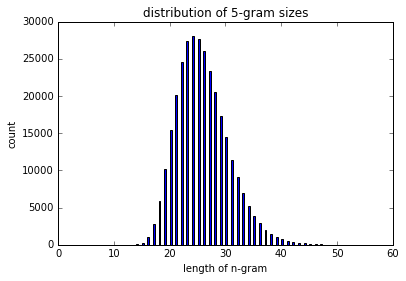

In [151]:
#!cat resul5t3_distribution_test | sort -k2rn > resul5t3_distribution_test.txt
!cat resul5t3_distribution_5g | sort -k2rn > resul5t3_distribution_5g.txt
#!head resul5t3_distribution_test.txt

%matplotlib inline
import matplotlib.pyplot as plt

sizes = {}
for line in open('resul5t3_distribution_5g.txt').read().strip().split('\n'):
    size, frequency = line.split('\t')
    size = int(size)
    frequency = int(frequency)
    sizes[size] = sizes.get(size, 0) + frequency

fig, ax = plt.subplots()
width = 0.35

distribution = ax.bar(sizes.keys(), sizes.values(), width, color='b')
ax.set_ylabel('count')
ax.set_xlabel('length of n-gram')
ax.set_title('distribution of 5-gram sizes')

plt.show()

## HW 5.3.1 OPTIONAL Question:

In [156]:
%%writefile HW5_3_Top10000Words.py
#!/usr/bin/python
from mrjob.job import MRJob 
from mrjob.step import MRStep
from mrjob.conf import combine_dicts
import heapq


class Top10000Words(MRJob):
    def jobconf(self):
        orig_jobconf = super(Top10000Words, self).jobconf()
        
        custom_jobconf = {
            'mapred.map.tasks' : 10,
            'mapred.reduce.tasks' : 10
        }

        return combine_dicts(orig_jobconf, custom_jobconf) 
    
    # Extract the unigrams from the 5-grams and yield for counting
    def mapper_unigram_count(self, _, ngram):
        unigrams = ngram.split()[:5]
        for unigram in unigrams:
            yield unigram, 1
    
    # identity mapper used to sort in MRJob
    def mapper_unigram_top10(self, key, value):
        yield key, value
    
    # Combiner for the unigram count
    def combiner_unigram_count(self, unigram, count):
        yield unigram, sum(count)

    # combine sums for each unigram and change the key, value to sort on count
    def reducer_unigram_count(self, unigram, count):
        yield None, (sum(count), unigram)
        
    # use a heap sort to yield the top10 unigrams by count
    def reducer_unigram_top10(self, _, unigram_count):
        for count, unigram in heapq.nlargest(10000, unigram_count):
            yield unigram, count
            
    # define the execution steps 
    def steps(self):
        return[MRStep(mapper=self.mapper_unigram_count,
                      combiner=self.combiner_unigram_count,
                      reducer=self.reducer_unigram_count),
               MRStep(mapper=self.mapper_unigram_top10,
                      reducer=self.reducer_unigram_top10)]
        
if __name__ == '__main__': 
    Top10000Words.run()

Overwriting HW5_3_Top10000Words.py


In [157]:
##### run it locally via python #####
!python HW5_3_Top10000Words.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t3_top10000_5g
!cat resul5t3_top10000_5g | sort -k2rn > resul5t3_top10000_5g.txt
!head resul5t3_top10000_5g.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_3_Top10000Words.cloudera.20160918.161132.474231
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_3_Top10000Words.cloudera.20160918.161132.474231/output...
Removing temp directory /tmp/HW5_3_Top10000Words.cloudera.20160918.161132.474231...
"the"	142036
"of"	96264
"to"	63784
"a"	41293
"in"	41031
"and"	40454
"that"	22726
"is"	20219
"be"	17409
"for"	14498


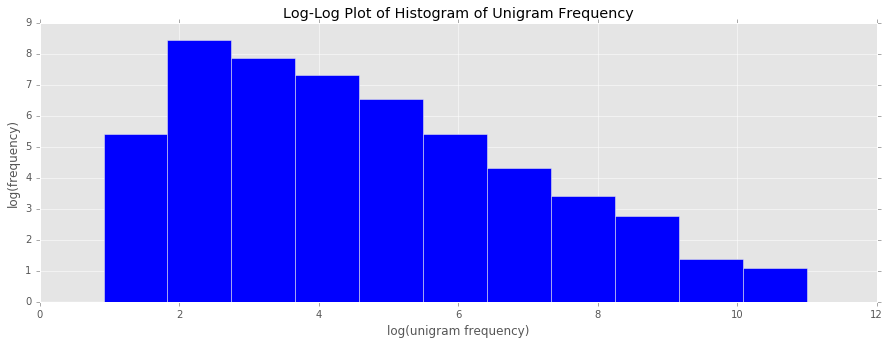

In [159]:
import csv
import math
import matplotlib

matplotlib.style.use('ggplot')
unigram_frequency = []


with open('resul5t3_top10000_5g.txt', 'r') as output_file:
    for row in csv.reader(output_file, delimiter = '\t'):
        log_index = int(math.log(int(row[1])))

        for i in range(len(unigram_frequency), log_index + 1):
            unigram_frequency.append(0)

        unigram_frequency[log_index] += 1

log_unigram_frequency = [math.log(x) if x != 0 else 0 for x in unigram_frequency]

# Create a histogram using matplotlib.

bin_count = len(log_unigram_frequency)

matplotlib.pyplot.figure(figsize=(15, 5))
matplotlib.pyplot.xlabel('log(unigram frequency)')
matplotlib.pyplot.ylabel('log(frequency)')
matplotlib.pyplot.title('Log-Log Plot of Histogram of Unigram Frequency')
matplotlib.pyplot.hist(range(0, bin_count), bin_count, weights = log_unigram_frequency, color='b');

#### Since the log-log plot is very close to a straight downward-sloped line, this shows that the original values follow a power law distribution.

## HW 5.4  Synonym detection over 2Gig of Data

### CREATE SYSTEMS TEST DATASET

In [161]:
%%writefile System_Tes5t_4.txt.txt
DocA	{'X':20, 'Y':30, 'Z':5}
DocB	{'X':100, 'Y':20}
DocC	{'M':5, 'N':20, 'Z':5}

Overwriting System_Tes5t_4.txt


In [165]:
!hdfs dfs -put System_Tes5t_4.txt /user/shihyu

put: `/user/shihyu/System_Tes5t_4.txt': File exists


## HW 5.4.1

### Run  SYSTEMS TEST DATASET

### By Hands:

From previous part, we have following cooccurrences:

    M	{N:20/5, Z:5/5}
    N	{M:5/20, Z:5/20}
    X	{Y:50/120, Z:5/120}
    Y	{X:120/50, Z:5/50}
    Z	{M:5/10, N:20/10, X:20/10, Y:30/10}


Therefore, we can compute the Jaccard index based on the interaction and the union of the two sets:

    M,N = 1/3
    M,X = 1/3
    M,Y = 1/3
    M,Z = 1/5
    N,X = 1/3
    N,Y = 1/3
    N,Z = 1/5
    X,Y = 1/3
    X,Z = 1/5
    Y,Z = 1/5

After taking logarithm, we have following result:

    M,N = -1.0986122886681098
    M,X = -1.0986122886681098
    M,Y = -1.0986122886681098
    M,Z = -1.6094379124341003
    N,X = -1.0986122886681098
    N,Y = -1.0986122886681098
    N,Z = -1.6094379124341003
    X,Y = -1.0986122886681098
    X,Z = -1.6094379124341003
    Y,Z = -1.6094379124341003

### Create dictionary file

In [170]:
!head -10000 resul5t3_top10000_5g.txt > ngrams_basis.txt
!head -10000 resul5t3_top10000_5g.txt | tail -1000 > ngrams_vocabulary_9001_10000.txt

In [35]:
%%writefile HW5_4_1_Strip.py
#!/usr/bin/python
import csv
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class NGramsStriped(MRJob):
    INPUT_PROTOCOL = RawProtocol

    
    #Load dictionary terms.
    
    def mapper_init(self):
        self.basis = set()
        self.vocabulary = set()

        with open('/mnt/ephemeral1/jupyter/notebooks/sychang/ngrams_basis.txt', 'r') as basis_file:
            self.basis = set([row[0] for row in csv.reader(basis_file, delimiter = '\t')])

        with open('/mnt/ephemeral1/jupyter/notebooks/sychang/ngrams_vocabulary_9001_10000.txt', 'r') as vocabulary_file:
            self.vocabulary = set([row[0] for row in csv.reader(vocabulary_file, delimiter = '\t')])

    
    # Yield the per-document stripes.
    
    def mapper(self, ngram, value):
        ngram = ngram.lower()

        # Parse the word counts according to what we are checking: 
        # system test data or the actual ngrams data.

        if value[0] == '{':
            word_counts = eval(value)
            self.basis.update(word_counts.keys())
        else:
            split_value = value.split('\t')
            ngram_count = int(split_value[0])

            word_counts = {}

            for word in ngram.split(' '):
                if word not in self.vocabulary:
                    continue

                if word in word_counts:
                    word_counts[word] += ngram_count
                else:
                    word_counts[word] = ngram_count

        # Emit all the stripes derived from the word count. 
        # Only include keys in the stripe if the key is in the vocabulary file.

        if len(word_counts) < 2:
            return

        for word, count in word_counts.iteritems():
            stripe = {
                key: value
                   for key, value in word_counts.iteritems() if key != word and key in self.basis
            }

            if len(stripe) == 0:
                continue

            stripe['*'] = count

            yield word, stripe

    
    # Sum the stripes.
    
    def combiner(self, word, stripes):
        yield word, self.combine_stripes(stripes)

    
    # Sum the stripes and then emit the coccurrence ratio. 
    
    def reducer(self, word, stripes):
        combined_stripe = self.combine_stripes(stripes)
        total_count = combined_stripe['*']

        ratio_stripe = {
            key: float(value) / float(total_count)
                for key, value in combined_stripe.iteritems() if key != '*'
        }

        yield word, ratio_stripe

    
    # Sum the stripes.
    
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

if __name__ == '__main__':
    NGramsStriped().run()

Overwriting HW5_4_1_Strip.py


In [248]:
##### run it locally via python #####
!python HW5_4_1_Strip.py System_Tes5t_4.txt > resul5t4_1_Strip_test
!cat resul5t4_1_Strip_test




No configs found; falling back on auto-configuration
Creating temp directory /tmp/HW5_4_1_Strip.cloudera.20160918.221821.177251
Running step 1 of 1...
Streaming final output from /tmp/HW5_4_1_Strip.cloudera.20160918.221821.177251/output...
Removing temp directory /tmp/HW5_4_1_Strip.cloudera.20160918.221821.177251...
"M"	{"Z": 1.0, "N": 4.0}
"N"	{"Z": 0.25, "M": 0.25}
"X"	{"Y": 0.4166666666666667, "Z": 0.041666666666666664}
"Y"	{"X": 2.4, "Z": 0.1}
"Z"	{"Y": 3.0, "X": 2.0, "M": 0.5, "N": 2.0}


### They are same as our hand calculation if we use the whole file of top 10000 dictionary.
### However, we will get nothing if we use the words ranked from 9001,-10,000 vocabulary set since no overlapping with system test data set and such vocabulary set. 

### Run A large subset of the Google n-grams dataset

In [423]:
# Using ngrams_vocabulary_9001_10000.txt and hadoop
!python HW5_4_1_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t4_1_Strip_g5
!cat resul5t4_1_Strip_g5 | head -20

Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Strip.cloudera.20160920.044138.255382
Running step 1 of 1...
Streaming final output from /tmp/HW5_4_1_Strip.cloudera.20160920.044138.255382/output...
Removing temp directory /tmp/HW5_4_1_Strip.cloudera.20160920.044138.255382...
"abnormalities"	{"reproductive": 1.0}
"amended"	{"valuation": 1.0}
"antigens"	{"switched": 1.0}
"anxieties"	{"beset": 1.0}
"arbitration"	{"pursuant": 1.0}
"arrows"	{"shower": 1.0, "bullets": 1.0}
"arterial"	{"selective": 0.504950495049505, "transplantation": 0.49504950495049505}
"ascending"	{"colon": 1.0}
"assaults"	{"temptations": 1.0}
"attaches"	{"tendon": 1.0}
"beset"	{"anxieties": 1.0}
"boil"	{"rack": 0.34710743801652894, "stirring": 0.6528925619834711}
"boom"	{"tin": 1.0}
"brook"	{"rugged": 1.0}
"bullets"	{"shower": 1.0, "arrows": 1.0}
"camps"	{"survivors": 1.0}
"champion"	{"toleration": 1.0}
"cherished"	{"recollections": 1.0}
"collectively"	{"exhaustive": 1.0}
"colon"	{"ascending": 1.0}


In [335]:
# Using ngrams_vocabulary_9001_10000.txt and hadoop python version should be 2.7
!hdfs dfs -put googlebooks-eng-all-5gram-20090715-0-filtered.txt /user/cloudera
!python HW5_4_1_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -r hadoop -v > resul5t4_1_Strip_g5
!cat resul5t4_1_Strip_g5 | head -10


put: `/user/cloudera/googlebooks-eng-all-5gram-20090715-0-filtered.txt': File exists
Looking for configs in /home/cloudera/.mrjob.conf
Looking for configs in /etc/mrjob.conf
Using configs in /etc/mrjob.conf
Active configuration:
{'bootstrap_mrjob': None,
 'check_input_paths': True,
 'cleanup': ['ALL'],
 'cleanup_on_failure': ['NONE'],
 'cmdenv': {},
 'hadoop_bin': None,
 'hadoop_extra_args': [],
 'hadoop_home': None,
 'hadoop_log_dirs': [],
 'hadoop_streaming_jar': None,
 'hadoop_tmp_dir': 'tmp/mrjob',
 'hadoop_version': None,
 'interpreter': ['/home/cloudera/anaconda2/bin/python'],
 'jobconf': {},
 'label': None,
 'libjars': [],
 'local_tmp_dir': '/tmp',
 'owner': 'cloudera',
 'python_archives': [],
 'python_bin': None,
 'setup': [],
 'setup_cmds': [],
 'setup_scripts': [],
 'sh_bin': ['sh', '-ex'],
 'steps_interpreter': None,
 'steps_python_bin': None,
 'strict_protocols': True,
 'upload_archives': [],
 'upload_files': []}
Looking for hadoop binary in $PATH...
Found hadoop binary: /u

In [ ]:

##### run it on emr #####
# s3 folder: s3://aws-logs-149687825236-us-east-1/elasticmapreduce/


#!python HW5_4_1_Strip.py s3://filtered-5grams/ -r emr --cleanup=NONE --no-output
# Output should be resul5t4_1_Strip_s3 since data source originally put at AMAZON s3

## HW 5.4.2

### Run  SYSTEMS TEST DATASET

## By Hand, Jaccard

We begin with the following relative occurrences:

    M	{N:20/5, Z:5/5}
    N	{M:5/20, Z:5/20}
    X	{Y:50/120, Z:5/120}
    Y	{X:120/50, Z:5/50}
    Z	{M:5/10, N:20/10, X:20/10, Y:30/10}


Therefore, we can compute the Jaccard index based on the union of two sets:

    M,N = 1/3
    M,X = 1/3
    M,Y = 1/3
    M,Z = 1/5
    N,X = 1/3
    N,Y = 1/3
    N,Z = 1/5
    X,Y = 1/3
    X,Z = 1/5
    Y,Z = 1/5

If we then take the logarithm, we would expect the following result:

    M,N = -1.0986122886681098
    M,X = -1.0986122886681098
    M,Y = -1.0986122886681098
    M,Z = -1.6094379124341003
    N,X = -1.0986122886681098
    N,Y = -1.0986122886681098
    N,Z = -1.6094379124341003
    X,Y = -1.0986122886681098
    X,Z = -1.6094379124341003
    Y,Z = -1.6094379124341003

## By Hand, Pearson Correlation

We start with the following co-occurrences:

    M	{N:20/5, Z:5/5}
    N	{M:5/20, Z:5/20}
    X	{Y:50/120, Z:5/120}
    Y	{X:120/50, Z:5/50}
    Z	{M:5/10, N:20/10, X:20/10, Y:30/10}

After normalization, we get the following:

    M	{N: 0.9701425001453319, Z: 0.24253562503633297}
    N	{M: 0.7071067811865475, Z: 0.7071067811865475}
    X	{Y: 0.9950371902099892, Z: 0.0995037190209989}
    Y	{X: 0.9991330730923519, Z: 0.04163054471218133}
    Z	{M: 0.1203858530857692, N: 0.4815434123430768, Y: 0.7223151185146152, X: 0.4815434123430768}

Computing the Pearson corrleation coefficients between each pair of vectors, we get the following:

    M,N = 0.17149858514250882
    M,X = 0.024133196686197622
    M,Y = 0.010096890182371906
    M,Z = 0.467165729979027
    N,X = 0.07035975447302917
    N,Y = 0.029437240470473188
    N,Z = 0.08512565307587484
    X,Y = 0.004142394023732023
    X,Z = 0.718730405972978
    Y,Z = 0.4811259494017159

By taking the logarithm of these coefficients values, we get the following:

    M,N = -1.7631802623080808
    M,X = -3.724166930448738
    M,Y = -4.595527805282158
    M,Z = -0.7610712020869566
    N,X = -2.6541338487006025
    N,Y = -3.5254947235340226
    N,Z = -2.4636268425786025
    X,Y = -5.48648139167468
    X,Z = -0.33026894849715877
    Y,Z = -0.7316261940848433

In [583]:
%%writefile HW5_4_1_Detection.py
#!/usr/bin/python
import csv
import math
import functools
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol
from sets import Set

class SynonymDetection(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    #global Symbols_Set = {}
    
    #Configuration options for different distance measures 
    
    
    
    def configure_options(self):
        super(SynonymDetection, self).configure_options()
        self.add_passthrough_option('--distance-type', type = 'string')

    
    # Normalize vector components 
    
    def mapper_normalize(self, word, rate_stripe):
        
        #Symbols_Set[word]=0

        # Compute the magnitude for the vector.

        magnitude = math.sqrt(sum([value ** 2 for value in rate_stripe.itervalues()]))

        # Divide each value in the vector by the magnitude 

        for key, value in rate_stripe.iteritems():
            normalized_value = value / magnitude
            #print normalized_value
            yield key, { word: normalized_value }

    
    # Combine the stripes.
    
    def combiner_normalize(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)

    
    #Combine the stripes.
    
    def reducer_normalize(self, word, transpose_stripes):
        #temp = self.combine_stripes(transpose_stripes)
        #print word
       
        yield word, self.combine_stripes(transpose_stripes)

    
    #Compute the Pearson coefficients based on the normalized vectors.
    
    def mapper_Pearson(self, word, transpose_stripe):
        
        #Symbols_Set = {}
        #Symbols_Set[word]=0
        
        #print transpose_stripe
        sorted_pairs = sorted(transpose_stripe.iteritems())
        #print sorted_pairs
        for i in range(0, len(sorted_pairs)):
            left_label, left_value = sorted_pairs[i]

            stripe = {}
            
            if len(sorted_pairs) < 2:
                
                right_label, right_value = sorted_pairs[i]
                partial_distance = left_value * right_value
                stripe[right_label] = partial_distance
                
            else: 

                for j in range(i + 1, len(sorted_pairs)):
                    right_label, right_value = sorted_pairs[j]
                    partial_distance = left_value * right_value

                    #if partial_distance > 0:
                    stripe[right_label] = partial_distance
            #print stripe
            yield left_label, stripe#, Symbols_Set

    
    #Sum the partial distances based on the data contained in the stripe.
    
    def combiner_Pearson(self, left_label, partial_stripes):
        yield left_label, self.combine_stripes(partial_stripes)

    
    #Sum the partial distances and take the logarithm for sorting.
    
    def reducer_Pearson(self, left_label, partial_stripes):
        total_stripe = self.combine_stripes(partial_stripes)
        #print total_stripe
        #total_stripe = partial_stripes
        #print partial_stripes, '%%%' 
        #print total_stripe.iteritems(), '###'
        
        #print(Symbols_Set.keys())
        for right_label, sum_distance in total_stripe.iteritems():
            #print right_label
            components = (left_label, right_label)
            
            yield components, math.log(sum_distance)
        
        ##### Consider non-related term as -1000
        #for right_label in Symbols_Set.iterkeys():
        #    if right_label in total_stripe.keys():
        #        components = (left_label, right_label) 
        #        log_sum_distance = math.log(total_stripe[right_label])
        #    else:
        #        components = (left_label, right_label) 
        #        log_sum_distance = -1000
        #    yield components, log_sum_distance
        
        
              
    
    #Emit pairs as stripes.
    
    def mapper_jaccard(self, word, rate_stripe):
        #nonzero_keys = [key for key, value in rate_stripe.iteritems() if value != 0]
        nonzero_keys = [key for key, value in rate_stripe.iteritems()]

        # Emit a stripe for each combination of values from rate_stripe

        sorted_keys = sorted(nonzero_keys)
        #print sorted_keys 
        for i in range(0, len(sorted_keys)):
            
            if len(sorted_keys) < 2:
                left_label = sorted_keys[i]
                stripe = {}
                right_label = sorted_keys[i]
                stripe[right_label] = 1
                
            else:    
                left_label = sorted_keys[i]

                stripe = {}

                for j in range(i + 1, len(sorted_keys)):
                    right_label = sorted_keys[j]
                    stripe[right_label] = 1

            yield left_label, stripe

        # Emit another stripe to use to get the total counts. 

        yield '*', { key: 1 for key in sorted_keys }

    
    #Sum the partial distances based on the data contained in the stripe.
    
    def combiner_jaccard(self, left_label, partial_stripes):
        yield left_label, self.combine_stripes(partial_stripes)

    
    #Reducer which aggregates the stripes and then divides by the total counts
    
    
    def reducer_jaccard(self, left_label, partial_stripes):
        total_stripe = self.combine_stripes(partial_stripes)
        #print component

        if left_label == '*':
            self.total_counts = total_stripe
            return

        for right_label, intersection in total_stripe.iteritems():
            component = (left_label, right_label)
            union = self.total_counts[left_label] + self.total_counts[right_label]

            # Subtract the logarithms instead of taking the logarithm of
            # the quotient to avoid potential underflow.

            jaccard_distance = math.log(intersection) - math.log(union - intersection)
            #print component
            yield component, jaccard_distance

   
    # Sum the stripes.
   
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

    
    # Define Mapreducer tasks.
    
    def steps(self):

        normalize_task = MRStep(
            mapper = self.mapper_normalize,
            combiner = self.combiner_normalize,
            reducer = self.reducer_normalize)

        # For Pearson_r calculation
        
        if self.options.distance_type == 'Pearson_r':
            distance_task = MRStep(
                mapper = self.mapper_Pearson,
                combiner = self.combiner_Pearson,
                reducer = self.reducer_Pearson)

        # For Jaccard calculation

        else:
            #distance_task = MRStep(
            #    mapper = self.mapper_jaccard,
            #    combiner = self.combiner_jaccard,
            #    reducer = self.reducer_jaccard)
               
            distance_task = MRStep(
                mapper = self.mapper_jaccard,
                combiner = self.combiner_jaccard,
                reducer = self.reducer_jaccard,
                jobconf = {
                    'mapreduce.job.reduces': 1
                })

        return [normalize_task, distance_task]

if __name__ == '__main__':
    SynonymDetection().run()

Overwriting HW5_4_1_Detection.py


In [584]:
##### run it locally via python #####
!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t4_1_Strip_test > resul5t4_1_Detection_Jaccard_test
!cat resul5t4_1_Detection_Jaccard_test

!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t4_1_Strip_test > resul5t4_1_Detection_Pearson_test
!cat resul5t4_1_Detection_Pearson_test


Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162332.009153
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.cloudera.20160920.162332.009153/output...
Removing temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162332.009153...
["M", "Y"]	-1.0986122886681098
["M", "X"]	-1.0986122886681098
["M", "Z"]	-1.6094379124341003
["M", "N"]	-1.0986122886681098
["N", "Y"]	-1.0986122886681098
["N", "X"]	-1.0986122886681098
["N", "Z"]	-1.6094379124341003
["X", "Y"]	-1.0986122886681098
["X", "Z"]	-1.6094379124341003
["Y", "Z"]	-1.6094379124341003
Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162332.583355
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.cloudera.20160920.162332.583355/output...
Removing temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162332.583355...
["M", "Y"]	-4.5955278052

### Results agree with Hand calculation for Jaccard and Pearson



### Run A large subset of the Google n-grams dataset

In [585]:
# Using ngrams_vocabulary_9001_10000.txt and run python locally 

!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t4_1_Strip_g5 > resul5t4_1_Detection_g5_Jaccard

!cat resul5t4_1_Detection_g5_Jaccard | head -10

!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t4_1_Strip_g5 > resul5t4_1_Detection_g5_Pearson_r

!cat resul5t4_1_Detection_g5_Pearson_r | head -10



Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162346.358587
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.cloudera.20160920.162346.358587/output...
Removing temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162346.358587...
["abnormalities", "abnormalities"]	0.0
["amended", "amended"]	0.0
["antigens", "antigens"]	0.0
["anxieties", "anxieties"]	0.0
["arbitration", "arbitration"]	0.0
["arrows", "shower"]	-1.0986122886681098
["arrows", "bullets"]	-1.0986122886681098
["arterial", "arterial"]	-1.0986122886681098
["arterial", "lobe"]	-0.6931471805599453
["arterial", "retention"]	-0.6931471805599453
Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Detection.cloudera.20160920.162346.958186
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.cloudera.20160920.162346.958186/output...
Removing temp directory /tmp/HW5_4_1_Det

In [376]:
# Using ngrams_vocabulary_9001_10000.txt and hadoop python version should be 2.7
!hdfs dfs -put googlebooks-eng-all-5gram-20090715-0-filtered.txt /user/sychang
!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t4_1_Strip_g5 -r hadoop > resul5t4_1_Detection_g5_Jaccard
!cat resul5t4_1_Detection_g5_Jaccard | head -10

put: `/user/cloudera/googlebooks-eng-all-5gram-20090715-0-filtered.txt': File exists
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW5_4_1_Detection.cloudera.20160919.205559.998140/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 2...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob8077564408171032888.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1473444507507_0231
  Submitted application application_1473444507507_0231
  The url to track the job: http://quickstart.c

In [377]:
# Using ngrams_vocabulary_9001_10000.txt and hadoop python version should be 2.7
!hdfs dfs -put googlebooks-eng-all-5gram-20090715-0-filtered.txt /user/sychang
!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t4_1_Strip_g5 -r hadoop > resul5t4_1_Detection_g5_Pearson_r
!cat resul5t4_1_Detection_g5_Pearson_r | head -10

put: `/user/cloudera/googlebooks-eng-all-5gram-20090715-0-filtered.txt': File exists
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW5_4_1_Detection.cloudera.20160919.205848.412338/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 2...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob1833153615972082032.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1473444507507_0233
  Submitted application application_1473444507507_0233
  The url to track the job: http://quickstart.c

## HW 5.5 Evaluation of synonyms that your discovered

In [587]:
### Get sorted similariarity results from HW5.4
!sort -k3nr resul5t4_1_Detection_g5_Jaccard > resul5t4_1_Detection_g5_Jaccard_sorted.txt
#!head -50 resul5t4_1_Detection_g5_Jaccard_sorted.txt
!sort -k3nr resul5t4_1_Detection_g5_Pearson_r > resul5t4_1_Detection_g5_Pearson_r_sorted.txt
#!head -50 resul5t4_1_Detection_g5_Pearson_r_sorted.txt


# test cosine.txt
#!sort -k3nr cosine.txt > resul5t4_1_Detection_g5_Pearson_r_sorted.txt

In [403]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/cloudera/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [404]:
!wget --quiet https://www.dropbox.com/sh/0cv65h44zylqwe3/AADbmhKuESCLaV_IntPhO2a2a/nltk_synonyms.py

In [618]:
-

In [676]:
!head -1000 resul5t4_1_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard9001.txt
synonym_results('jaccard9001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
recess                  1         0        10     1.000     0.091     0.167
semantic                1         0         0     1.000     1.000     1.000
tidings                 1         0         5     1.000     0.167     0.286
pursuant                1         0         0     1.000     1.000     1.000
beset                   1         0        13     1.000     0.071     0.133
poorly                  1         0         9     1.000     0.100     0.182
tore                    1         0        14     1.000     0.067     0.125
homage                  1         0         1     1.000     0.500     0.667
brook                   1         0        12     1.000     0.077     0.143


Stats Summary
--------------------------
Precision:      0.955
Recall:   

In [677]:
!head -1000 resul5t4_1_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson9001.txt
synonym_results('Pearson9001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
recess                  1         0        10     1.000     0.091     0.167
semantic                1         0         0     1.000     1.000     1.000
tidings                 1         0         5     1.000     0.167     0.286
pursuant                1         0         0     1.000     1.000     1.000
beset                   1         0        13     1.000     0.071     0.133
poorly                  1         0         9     1.000     0.100     0.182
tore                    1         0        14     1.000     0.067     0.125
homage                  1         0         1     1.000     0.500     0.667
brook                   1         0        12     1.000     0.077     0.143


Stats Summary
--------------------------
Precision:      0.955
Recall:   

## HW5.6 (Optional): Below I run locally since I can control CPU usage at my local computer but I can not control hwardware resources at AWS.

#### Strip files preparation for different vocabulary sets


In [595]:
### preparing different vocabulary sets
### 8001,-10,000; 7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000
!head -10000 resul5t3_top10000_5g.txt > ngrams_basis.txt
!head -10000 resul5t3_top10000_5g.txt | tail -2000 > ngrams_vocabulary_8001_10000.txt
!head -10000 resul5t3_top10000_5g.txt | tail -3000 > ngrams_vocabulary_7001_10000.txt
!head -10000 resul5t3_top10000_5g.txt | tail -4000 > ngrams_vocabulary_6001_10000.txt
!head -10000 resul5t3_top10000_5g.txt | tail -5000 > ngrams_vocabulary_5001_10000.txt
!head -10000 resul5t3_top10000_5g.txt | tail -7000 > ngrams_vocabulary_3001_10000.txt
!head -10000 resul5t3_top10000_5g.txt | tail -9000 > ngrams_vocabulary_1001_10000.txt

In [631]:
%%writefile HW5_6_Strip.py
#!/usr/bin/python
import csv
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class NGramsStriped(MRJob):
    INPUT_PROTOCOL = RawProtocol

    
    #Load dictionary terms.
    
    def mapper_init(self):
        self.basis = set()
        self.vocabulary = set()

        with open('/home/cloudera/ngrams_basis.txt', 'r') as basis_file:
            self.basis = set([row[0] for row in csv.reader(basis_file, delimiter = '\t')])

            
        #############CHANGE ME for different vocabulary sets #################    
        with open('/home/cloudera/ngrams_vocabulary_8001_10000.txt', 'r') as vocabulary_file:
            self.vocabulary = set([row[0] for row in csv.reader(vocabulary_file, delimiter = '\t')])

    
    # Yield the per-document stripes.
    
    def mapper(self, ngram, value):
        ngram = ngram.lower()

        # Parse the word counts according to what we are checking: 
        # system test data or the actual ngrams data.

        if value[0] == '{':
            word_counts = eval(value)
            self.basis.update(word_counts.keys())
        else:
            split_value = value.split('\t')
            ngram_count = int(split_value[0])

            word_counts = {}

            for word in ngram.split(' '):
                if word not in self.vocabulary:
                    continue

                if word in word_counts:
                    word_counts[word] += ngram_count
                else:
                    word_counts[word] = ngram_count

        # Emit all the stripes derived from the word count. 
        # Only include keys in the stripe if the key is in the vocabulary file.

        if len(word_counts) < 2:
            return

        for word, count in word_counts.iteritems():
            stripe = {
                key: value
                   for key, value in word_counts.iteritems() if key != word and key in self.basis
            }

            if len(stripe) == 0:
                continue

            stripe['*'] = count

            yield word, stripe

    
    # Sum the stripes.
    
    def combiner(self, word, stripes):
        yield word, self.combine_stripes(stripes)

    
    # Sum the stripes and then emit the coccurrence ratio. 
    
    def reducer(self, word, stripes):
        combined_stripe = self.combine_stripes(stripes)
        total_count = combined_stripe['*']

        ratio_stripe = {
            key: float(value) / float(total_count)
                for key, value in combined_stripe.iteritems() if key != '*'
        }

        yield word, ratio_stripe

    
    # Sum the stripes.
    
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

if __name__ == '__main__':
    NGramsStriped().run()

Overwriting HW5_6_Strip.py


In [632]:
# Using ngrams_vocabulary_1001_10000.txt 
#!python HW5_6_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t6_1001_Strip_g5
#!cat resul5t6_1001_Strip_g5 | head -5


# Using ngrams_vocabulary_3001_10000.txt 
#!python HW5_6_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t6_3001_Strip_g5
#!cat resul5t6_3001_Strip_g5 | head -5


# Using ngrams_vocabulary_5001_10000.txt
#!python HW5_6_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t6_5001_Strip_g5
#!cat resul5t6_5001_Strip_g5 | head -5


# Using ngrams_vocabulary_6001_10000.txt
#!python HW5_6_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t6_6001_Strip_g5
#!cat resul5t6_6001_Strip_g5 | head -5


# Using ngrams_vocabulary_7001_10000.txt
#!python HW5_6_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t6_7001_Strip_g5
#!cat resul5t6_7001_Strip_g5 | head -5


# Using ngrams_vocabulary_8001_10000.txt
!python HW5_6_Strip.py googlebooks-eng-all-5gram-20090715-0-filtered.txt > resul5t6_8001_Strip_g5
!cat resul5t6_8001_Strip_g5 | head -5

Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_6_Strip.cloudera.20160920.181952.899842
Running step 1 of 1...
Streaming final output from /tmp/HW5_6_Strip.cloudera.20160920.181952.899842/output...
Removing temp directory /tmp/HW5_6_Strip.cloudera.20160920.181952.899842...
"abnormalities"	{"reproductive": 1.0}
"abrupt"	{"halt": 1.0}
"abused"	{"blamed": 1.0}
"accepts"	{"agrees": 1.0}
"accomplishment"	{"adorned": 1.0}


#### Run hadoop to get Detection results


In [647]:
# Using ngrams_vocabulary_1001_10000.txt and run python locally Time: 6 mins, 3440858L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_1001_Strip_g5 > resul5t6_1001_Detection_g5_Jaccard

#!sort -k3nr resul5t6_1001_Detection_g5_Jaccard > resul5t6_1001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_1001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_1001_Strip_g5 > resul5t6_1001_Detection_g5_Pearson_r

#!sort -k3nr resul5t6_1001_Detection_g5_Pearson_r > resul5t6_1001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_1001_Detection_g5_Pearson_r_sorted.txt | head -5



# Using ngrams_vocabulary_3001_10000.txt and run python locally Time: 4 mins, 540984L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_3001_Strip_g5 > resul5t6_3001_Detection_g5_Jaccard

#!sort -k3nr resul5t6_3001_Detection_g5_Jaccard > resul5t6_3001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_3001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_3001_Strip_g5 > resul5t6_3001_Detection_g5_Pearson_r

#!sort -k3nr resul5t6_3001_Detection_g5_Pearson_r > resul5t6_3001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_3001_Detection_g5_Pearson_r_sorted.txt | head -5



# Using ngrams_vocabulary_5001_10000.txt and run python locally Time: 1 mins, 130465L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_5001_Strip_g5 > resul5t6_5001_Detection_g5_Jaccard

#!sort -k3nr resul5t6_5001_Detection_g5_Jaccard > resul5t6_5001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_5001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_5001_Strip_g5 > resul5t6_5001_Detection_g5_Pearson_r

#!sort -k3nr resul5t6_5001_Detection_g5_Pearson_r > resul5t6_5001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_5001_Detection_g5_Pearson_r_sorted.txt | head -5




# Using ngrams_vocabulary_6001_10000.txt and run python locally Time: 12s, 63876L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_6001_Strip_g5 > resul5t6_6001_Detection_g5_Jaccard

#!sort -k3nr resul5t6_6001_Detection_g5_Jaccard > resul5t6_6001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_6001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_6001_Strip_g5 > resul5t6_6001_Detection_g5_Pearson_r

#!sort -k3nr resul5t6_6001_Detection_g5_Pearson_r > resul5t6_6001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_6001_Detection_g5_Pearson_r_sorted.txt | head -5




# Using ngrams_vocabulary_7001_10000.txt and run python locally Time: 5s, 1329L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_7001_Strip_g5 > resul5t6_7001_Detection_g5_Jaccard

#!sort -k3nr resul5t6_7001_Detection_g5_Jaccard > resul5t6_7001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_7001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_7001_Strip_g5 > resul5t6_7001_Detection_g5_Pearson_r

#!sort -k3nr resul5t6_7001_Detection_g5_Pearson_r > resul5t6_7001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_7001_Detection_g5_Pearson_r_sorted.txt | head -5



# Using ngrams_vocabulary_8001_10000.txt and run python locally Time: 3s, 482L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_8001_Strip_g5 > resul5t6_8001_Detection_g5_Jaccard

!sort -k3nr resul5t6_8001_Detection_g5_Jaccard > resul5t6_8001_Detection_g5_Jaccard_sorted.txt

!cat resul5t6_8001_Detection_g5_Jaccard_sorted.txt | head -5

!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_8001_Strip_g5 > resul5t6_8001_Detection_g5_Pearson_r

!sort -k3nr resul5t6_8001_Detection_g5_Pearson_r > resul5t6_8001_Detection_g5_Pearson_r_sorted.txt

!cat resul5t6_8001_Detection_g5_Pearson_r_sorted.txt | head -5


Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Detection.cloudera.20160921.011026.222050
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.cloudera.20160921.011026.222050/output...
Removing temp directory /tmp/HW5_4_1_Detection.cloudera.20160921.011026.222050...
["abnormalities", "abnormalities"]	0.0
["abrupt", "abrupt"]	0.0
["abused", "abused"]	0.0
["accepts", "contractor"]	0.0
["accepts", "draught"]	0.0
Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW5_4_1_Detection.cloudera.20160921.011027.096525
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW5_4_1_Detection.cloudera.20160921.011027.096525/output...
Removing temp directory /tmp/HW5_4_1_Detection.cloudera.20160921.011027.096525...
["boil", "boil"]	2.2204460492503128e-16
["convent", "convent"]	2.2204460492503128e-16
["foe", "foe"]	2.2204460492503128e-16
["inverted", "inverted"]	2.2204460492503128e-16
["miseries", "mi

In [613]:
# Using ngrams_vocabulary_1001_10000.txt and run hadoop locally Time: 10 mins, 3440858L
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_1001_Strip_g5 -r hadoop > resul5t6_1001_Detection_g5_Jaccard
# CPU TIme (ms): 149880
!sort -k3nr resul5t6_1001_Detection_g5_Jaccard > resul5t6_1001_Detection_g5_Jaccard_sorted.txt

!cat resul5t6_1001_Detection_g5_Jaccard_sorted.txt | head -5

!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_1001_Strip_g5 -r hadoop > resul5t6_1001_Detection_g5_Pearson_r
# CPU TIme (ms): 96100
!sort -k3nr resul5t6_1001_Detection_g5_Pearson_r > resul5t6_1001_Detection_g5_Pearson_r_sorted.txt

!cat resul5t6_1001_Detection_g5_Pearson_r_sorted.txt | head -5


# Using ngrams_vocabulary_3001_10000.txt and run hadoop locally Time: 6 mins 40 s,
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_3001_Strip_g5 -r hadoop > resul5t6_3001_Detection_g5_Jaccard
# CPU TIme (ms): 89930
#!sort -k3nr resul5t6_3001_Detection_g5_Jaccard > resul5t6_3001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_1001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_3001_Strip_g5 -r hadoop > resul5t6_3001_Detection_g5_Pearson_r
# CPU TIme (ms): 57660
#!sort -k3nr resul5t6_3001_Detection_g5_Pearson_r > resul5t6_3001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_3001_Detection_g5_Pearson_r_sorted.txt | head -5



# Using ngrams_vocabulary_5001_10000.txt and run hadoop locally Time: 1 mins 40 s
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_5001_Strip_g5 -r hadoop > resul5t6_5001_Detection_g5_Jaccard
# CPU TIme (ms): 64230
#!sort -k3nr resul5t6_5001_Detection_g5_Jaccard > resul5t6_5001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_5001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_5001_Strip_g5 -r hadoop > resul5t6_5001_Detection_g5_Pearson_r
# CPU TIme (ms): 41190
#!sort -k3nr resul5t6_5001_Detection_g5_Pearson_r > resul5t6_5001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_5001_Detection_g5_Pearson_r_sorted.txt | head -5




# Using ngrams_vocabulary_6001_10000.txt and run hadoop locally Time: 20s
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_6001_Strip_g5 -r hadoop > resul5t6_6001_Detection_g5_Jaccard
# CPU TIme (ms): 32890
#!sort -k3nr resul5t6_6001_Detection_g5_Jaccard > resul5t6_6001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_6001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_6001_Strip_g5 -r hadoop > resul5t6_6001_Detection_g5_Pearson_r
# CPU TIme (ms): 18700 
#!sort -k3nr resul5t6_6001_Detection_g5_Pearson_r > resul5t6_6001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_6001_Detection_g5_Pearson_r_sorted.txt | head -5



# Using ngrams_vocabulary_7001_10000.txt and run hadoop locally Time: 9s
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_7001_Strip_g5 -r hadoop > resul5t6_7001_Detection_g5_Jaccard
# CPU TIme (ms): 13620
#!sort -k3nr resul5t6_7001_Detection_g5_Jaccard > resul5t6_7001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_7001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_7001_Strip_g5 -r hadoop > resul5t6_7001_Detection_g5_Pearson_r
# CPU TIme (ms): 10580
#!sort -k3nr resul5t6_7001_Detection_g5_Pearson_r > resul5t6_7001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_7001_Detection_g5_Pearson_r_sorted.txt | head -5



# Using ngrams_vocabulary_8001_10000.txt and run hadoop locally Time: 5s
# Need verify what vocabulars file used at HW5_4_1_Detection.py 

#!python HW5_4_1_Detection.py --distance-type=Jaccard resul5t6_8001_Strip_g5 -r hadoop > resul5t6_8001_Detection_g5_Jaccard
# CPU TIme (ms): 11670
#!sort -k3nr resul5t6_8001_Detection_g5_Jaccard > resul5t6_8001_Detection_g5_Jaccard_sorted.txt

#!cat resul5t6_8001_Detection_g5_Jaccard_sorted.txt | head -5

#!python HW5_4_1_Detection.py --distance-type=Pearson_r resul5t6_8001_Strip_g5 -r hadoop > resul5t6_8001_Detection_g5_Pearson_r
# CPU TIme (ms): 9270
#!sort -k3nr resul5t6_8001_Detection_g5_Pearson_r > resul5t6_8001_Detection_g5_Pearson_r_sorted.txt

#!cat resul5t6_8001_Detection_g5_Pearson_r_sorted.txt | head -5





Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW5_4_1_Detection.cloudera.20160920.173301.781151/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 2...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob7101302273536608371.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1473444507507_0235
  Submitted application application_1473444507507_0235
  The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0235/
  Running job: job_1473444507507_0

In [614]:
!cat resul5t6_1001_Detection_g5_Pearson_r_sorted.txt | head -5 | head -5

["confident", "murderer"]	0.0
["confident", "succumbed"]	0.0
["confident", "worry"]	0.0
["damaging", "mistakes"]	0.0
["lingered", "restaurant"]	0.0
cat: write error: Broken pipe


#### Collect data and plot, Generate the following graphs: -
####- vocabulary size (X-Axis) versus CPU time for indexing
####-- vocabulary size (X-Axis) versus number of pairs processed 
####-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

In [622]:
# Using ngrams_vocabulary_1001_10000.txt 
!head -1000 resul5t6_1001_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard1001.txt
# Need change files open in function synonym_summary_stats
synonym_results('jaccard1001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
vexed                   1         6        38     0.143     0.026     0.043


Stats Summary
--------------------------
Precision:      0.143
Recall:         0.026
F1:             0.087


In [621]:
# Using ngrams_vocabulary_1001_10000.txt 
!head -1000 resul5t6_1001_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson1001.txt
# Need change files open in function synonym_summary_stats
synonym_results('Pearson1001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
quoted                  1         0         1     1.000     0.500     0.667
guess                   1        43        23     0.023     0.042     0.029
noticed                 2        29        10     0.065     0.167     0.093
venture                 1        31         8     0.031     0.111     0.049


Stats Summary
--------------------------
Precision:      0.280
Recall:         0.205
F1:             0.473


In [634]:
# Using ngrams_vocabulary_3001_10000.txt 
!head -1000 resul5t6_3001_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard3001.txt
# Need change files open in function synonym_summary_stats
synonym_results('jaccard3001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
alien                   1         0        12     1.000     0.077     0.143
formative               1         0         2     1.000     0.333     0.500
designate               1         0        12     1.000     0.077     0.143
premium                 1         0         5     1.000     0.167     0.286
disadvantage            1         0         2     1.000     0.333     0.500
gifted                  1         0         9     1.000     0.100     0.182
realise                 1        41        17     0.024     0.056     0.033
worrying                1        41        15     0.024     0.062     0.034
discount                1         0        11     1.000     0.083     0.154


Stats Summary
--------------------------
Precision:      0.824
Recall:   

In [635]:
# Using ngrams_vocabulary_3001_10000.txt  
!head -1000 resul5t6_3001_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson3001.txt
# Need change files open in function synonym_summary_stats
synonym_results('Pearson3001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
alien                   1         0        12     1.000     0.077     0.143
formative               1         0         2     1.000     0.333     0.500
designate               1         0        12     1.000     0.077     0.143
premium                 1         0         5     1.000     0.167     0.286
disadvantage            1         0         2     1.000     0.333     0.500
gifted                  1         0         9     1.000     0.100     0.182
realise                 1        42        17     0.023     0.056     0.033
worrying                1        41        15     0.024     0.062     0.034
discount                1         0        11     1.000     0.083     0.154


Stats Summary
--------------------------
Precision:      0.815
Recall:   

In [637]:
# Using ngrams_vocabulary_5001_10000.txt 
!head -1000 resul5t6_5001_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard5001.txt
# Need change files open in function synonym_summary_stats
synonym_results('jaccard5001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
adorned                 1         0        10     1.000     0.091     0.167
alien                   1         0        12     1.000     0.077     0.143
acres                   1         0         9     1.000     0.100     0.182
affirm                  1         0        11     1.000     0.083     0.154
anew                    1         0         1     1.000     0.500     0.667
arrow                   1         0         1     1.000     0.500     0.667
asset                   1         0         1     1.000     0.500     0.667
accomplishment          1         0         5     1.000     0.167     0.286
aversion                1         0         3     1.000     0.250     0.400


Stats Summary
--------------------------
Precision:      1.000
Recall:   

In [638]:
# Using ngrams_vocabulary_5001_10000.txt  
!head -1000 resul5t6_5001_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson5001.txt
# Need change files open in function synonym_summary_stats
synonym_results('Pearson5001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
adorned                 1         0        10     1.000     0.091     0.167
alien                   1         0        12     1.000     0.077     0.143
acres                   1         0         9     1.000     0.100     0.182
affirm                  1         0        11     1.000     0.083     0.154
anew                    1         0         1     1.000     0.500     0.667
arrow                   1         0         1     1.000     0.500     0.667
asset                   1         0         1     1.000     0.500     0.667
painter                 1         0         6     1.000     0.143     0.250
accomplishment          1         0         5     1.000     0.167     0.286


Stats Summary
--------------------------
Precision:      1.000
Recall:   

In [640]:
# Using ngrams_vocabulary_6001_10000.txt 
!head -1000 resul5t6_6001_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard6001.txt
# Need change files open in function synonym_summary_stats
synonym_results('jaccard6001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
adorned                 1         0        10     1.000     0.091     0.167
admirable               1         0         0     1.000     1.000     1.000
affirm                  1         0        11     1.000     0.083     0.154
accomplishment          1         0         5     1.000     0.167     0.286
accounting              1         0         9     1.000     0.100     0.182
aboard                  1         0         3     1.000     0.250     0.400
absorb                  1         0        18     1.000     0.053     0.100


Stats Summary
--------------------------
Precision:      1.000
Recall:         0.249
F1:             0.798


In [641]:
# Using ngrams_vocabulary_6001_10000.txt  
!head -1000 resul5t6_6001_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson6001.txt
# Need change files open in function synonym_summary_stats
synonym_results('Pearson6001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
adorned                 1         0        10     1.000     0.091     0.167
admirable               1         0         0     1.000     1.000     1.000
substrate               1         0         1     1.000     0.500     0.667
affirm                  1         0        11     1.000     0.083     0.154
chorus                  1         0         4     1.000     0.200     0.333
hinder                  1         0        11     1.000     0.083     0.154
boil                    1         0         6     1.000     0.143     0.250
safeguard               1         0         3     1.000     0.250     0.400
debtor                  1         0         1     1.000     0.500     0.667


Stats Summary
--------------------------
Precision:      1.000
Recall:   

In [644]:
# Using ngrams_vocabulary_7001_10000.txt 
!head -1000 resul5t6_7001_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard7001.txt
# Need change files open in function synonym_summary_stats
synonym_results('jaccard7001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
coach                   1         0        18     1.000     0.053     0.100
semantic                1         0         0     1.000     1.000     1.000
dynasty                 1         0         0     1.000     1.000     1.000
mansion                 1         0         9     1.000     0.100     0.182
localized               1         0         7     1.000     0.125     0.222
shattered               1         0         2     1.000     0.333     0.500
inverse                 1         0         2     1.000     0.333     0.500
catastrophe             1         0         4     1.000     0.200     0.333
homage                  1         0         1     1.000     0.500     0.667


Stats Summary
--------------------------
Precision:      0.950
Recall:   

In [645]:
# Using ngrams_voabulary_7001_10000.txt  
!head -1000 resul5t6_7001_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson7001.txt
# Need change files open in function synonym_summary_stats
synonym_results('Pearson7001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
coach                   1         0        18     1.000     0.053     0.100
semantic                1         0         0     1.000     1.000     1.000
dynasty                 1         0         0     1.000     1.000     1.000
zinc                    1         0         2     1.000     0.333     0.500
mansion                 1         0         9     1.000     0.100     0.182
localized               1         0         7     1.000     0.125     0.222
shattered               1         0         2     1.000     0.333     0.500
uneven                  1         0         4     1.000     0.200     0.333
catastrophe             1         0         4     1.000     0.200     0.333


Stats Summary
--------------------------
Precision:      0.957
Recall:   

In [648]:
# Using ngrams_vocabulary_8001_10000.txt 
!head -1000 resul5t6_8001_Detection_g5_Jaccard_sorted.txt | cut -f 1 > jaccard8001.txt
# Need change files open in function synonym_summary_stats
synonym_results('jaccard8001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
semantic                1         0         0     1.000     1.000     1.000
dynasty                 1         0         0     1.000     1.000     1.000
zinc                    1         0         2     1.000     0.333     0.500
yonder                  1         0         1     1.000     0.500     0.667
shattered               1         0         2     1.000     0.333     0.500
inverse                 1         0         2     1.000     0.333     0.500
homage                  1         0         1     1.000     0.500     0.667
obstinate               1         0         8     1.000     0.111     0.200
fountain                1         0         6     1.000     0.143     0.250


Stats Summary
--------------------------
Precision:      0.939
Recall:   

In [649]:
# Using ngrams_vocabulary_8001_10000.txt  
!head -1000 resul5t6_8001_Detection_g5_Pearson_r_sorted.txt | cut -f 1 > Pearson8001.txt
# Need change files open in function synonym_summary_stats
synonym_results('Pearson8001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
inverse                 1         0         2     1.000     0.333     0.500
semantic                1         0         0     1.000     1.000     1.000
dynasty                 1         0         0     1.000     1.000     1.000
zinc                    1         0         2     1.000     0.333     0.500
yonder                  1         0         1     1.000     0.500     0.667
shattered               1         0         2     1.000     0.333     0.500
uneven                  1         0         4     1.000     0.200     0.333
homage                  1         0         1     1.000     0.500     0.667
obstinate               1         0         8     1.000     0.111     0.200


Stats Summary
--------------------------
Precision:      0.939
Recall:   

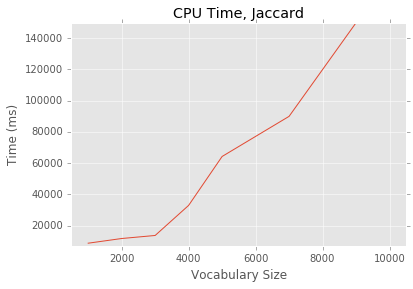

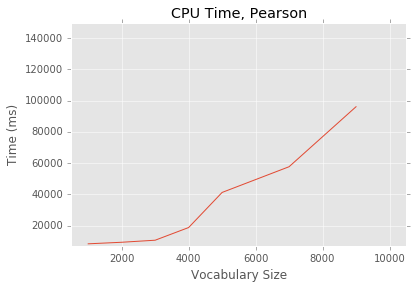

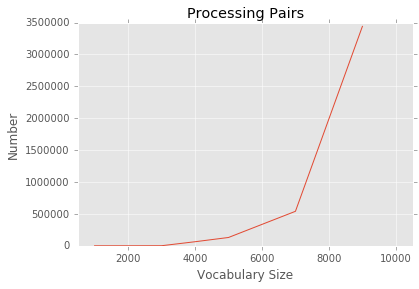

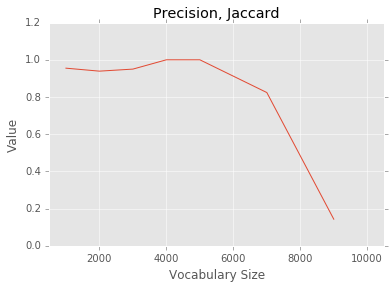

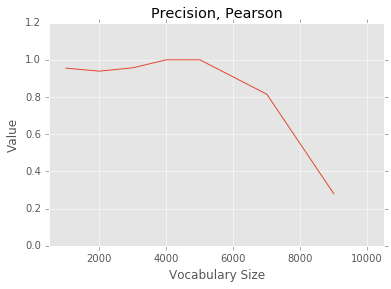

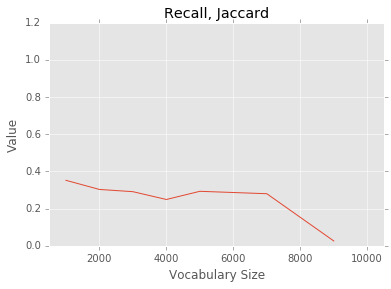

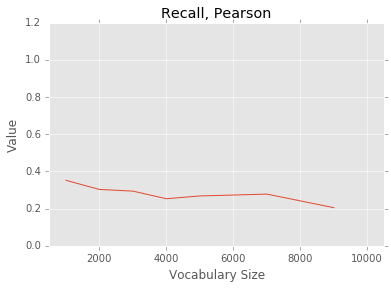

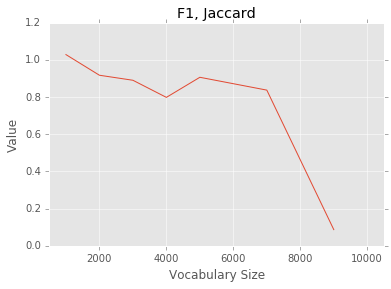

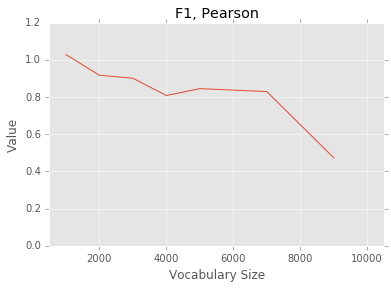

In [661]:
import numpy as np
import matplotlib.pyplot as plt


####- vocabulary size (X-Axis) versus CPU time for indexing
v_size = [1000, 2000, 3000, 4000, 5000, 7000, 9000]
cpu_time_Jaccard = [8670, 11670, 13620, 32890, 64230, 89930, 149880]
cpu_time_Pearson = [8270, 9270, 10580, 18700, 41190, 57660, 96100]

plt.xlabel('Vocabulary Size')
plt.ylabel('Time (ms)')
plt.axis([500, 10500, 7000, 150000])
plt.title('CPU Time, Jaccard')
plt.plot(v_size, cpu_time_Jaccard)
plt.show()


plt.xlabel('Vocabulary Size')
plt.ylabel('Time (ms)')
plt.axis([500, 10500, 7000, 150000])
plt.title('CPU Time, Pearson')
plt.plot(v_size, cpu_time_Pearson)
plt.show()


####-- vocabulary size (X-Axis) versus number of pairs processed

pairs = [147, 482, 1329, 63876, 130465, 540984, 3440858]


plt.xlabel('Vocabulary Size')
plt.ylabel('Number')
plt.axis([500, 10500, 100, 3500000])
plt.title('Processing Pairs')
plt.plot(v_size, pairs)
plt.show()

####-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

Precision_Jaccard = [0.955, 0.939, 0.950, 1.000, 1.000, 0.824, 0.143]
Precision_Pearson = [0.955, 0.939, 0.957, 1.000, 1.000, 0.815, 0.280]

plt.xlabel('Vocabulary Size')
plt.ylabel('Value')
plt.axis([500, 10500, 0, 1.2])
plt.title('Precision, Jaccard')
plt.plot(v_size, Precision_Jaccard)
plt.show()

plt.xlabel('Vocabulary Size')
plt.ylabel('Value')
plt.axis([500, 10500, 0, 1.2])
plt.title('Precision, Pearson')
plt.plot(v_size, Precision_Pearson)
plt.show()

Recall_Jaccard = [0.352, 0.303, 0.291, 0.249, 0.293, 0.280, 0.026]
Recall_Pearson = [0.352, 0.303, 0.294, 0.253, 0.268, 0.278, 0.205]

plt.xlabel('Vocabulary Size')
plt.ylabel('Value')
plt.axis([500, 10500, 0, 1.2])
plt.title('Recall, Jaccard')
plt.plot(v_size, Recall_Jaccard)
plt.show()

plt.xlabel('Vocabulary Size')
plt.ylabel('Value')
plt.axis([500, 10500, 0, 1.2])
plt.title('Recall, Pearson')
plt.plot(v_size, Recall_Pearson)
plt.show()

F1_Jaccard = [1.028, 0.917, 0.890, 0.798, 0.906, 0.837, 0.087]
F1_Pearson = [1.028, 0.917, 0.901, 0.808, 0.845, 0.829, 0.473]

plt.xlabel('Vocabulary Size')
plt.ylabel('Value')
plt.axis([500, 10500, 0, 1.2])
plt.title('F1, Jaccard')
plt.plot(v_size, F1_Jaccard)
plt.show()

plt.xlabel('Vocabulary Size')
plt.ylabel('Value')
plt.axis([500, 10500, 0, 1.2])
plt.title('F1, Pearson')
plt.plot(v_size, F1_Pearson)
plt.show()



#### Comments for HW5.6:

1. When vocabulary size increases, porcssing burdens increase by burning more CPU since more pairs are processed.

2. ML related performance metrics, precision, recall, and F1 score, degrade due to larger space to explore (predict) but our training set is still the previous 1000 pairs.

3. Jaccard similarity ML performance degrades more seriouslly compared to Pearson similarity. 


## HW 5.7 (Optional)

In [665]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [674]:
import csv
import numpy

from __future__ import division
from nltk_synonyms import synonyms
from nltk.corpus import stopwords


def synonym_results_stop(pairs_file_name):
    with open(pairs_file_name, 'r') as pairs_file:
        pairs = [eval(line) for line in pairs_file]

    pred_synonyms = {}
    stop_words_English = stopwords.words('english') 
    #print stop_words_English

    # Identify the predicted synonyms represented by the best scoring pairs.

    for word1, word2 in pairs:
        if word1 not in stop_words_English and word1 not in stop_words_English:
            if word1 not in pred_synonyms:
                pred_synonyms[word1] = set([word2])
            else:
                pred_synonyms[word1].add(word2)

            if word2 not in pred_synonyms:
                pred_synonyms[word2] = set([word1])
            else:
                pred_synonyms[word2].add(word1)
        else:
            continue

    # Load the basis words. #### Here also need to be changed for different vocaublary set ####

    with open('/home/cloudera/ngrams_vocabulary_9001_10000.txt', 'r') as basis_file:
        vocabulary = set([row[0] for row in csv.reader(basis_file, delimiter = '\t')])

    precisions = []
    recalls = []

    # Print the recall/precision/f1 for each word

    row_format = '{:<15s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}'
    print_counter = 0

    print 'Words with true positives value greater then 0 (show at most 10):\n'

    print row_format.format(
        'word', 'True_P', 'False_P', 'False_N', 'Precision', 'Recall', 'F1')

    print '-------------------------------------------------------------------------------------------------'

    for word, predictions in pred_synonyms.iteritems():
        true_synonyms = set(synonyms(word))

        true_pos = len(true_synonyms.intersection(predictions))
        false_pos = len(predictions.difference(true_synonyms))
        false_neg = len(true_synonyms.difference(predictions))

        if true_pos == 0:
            continue

        precision = true_pos / (true_pos + false_pos)
        precisions.append(precision)
        precision_string = '{:6.3f}'.format(precision)

        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
        recall_string = '{:6.3f}'.format(recall)

        if precision > 0 or recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
            f1_string = '{:6.3f}'.format(f1)
        else:
            f1_string = None
        print_counter += 1
        if print_counter < 10:
            print row_format.format(
                word, str(true_pos), str(false_pos), str(false_neg),
                precision_string, recall_string, f1_string)
        else:
            continue

    # Print the macro stats for the whole set of words.

    precision_macro = numpy.mean(precisions)
    recall_macro = numpy.mean(recalls)

    if precision_macro > 0 or recall_macro > 0:
        f1_macro = 2 * 2 * precision_macro * recall_macro / (precision_macro + recall_macro)
    else:
        f1_macro = 0

    print '\n\nStats Summary'
    print '--------------------------'
    print '{:<15s} {:2.3f}'.format('Precision:', precision_macro)
    print '{:<15s} {:2.3f}'.format('Recall:', recall_macro)
    print '{:<15s} {:2.3f}'.format('F1:', f1_macro)

#### From following results, we find that the precision, recall and F1 scores are almost the same compared to HW 5.5 except Pearson case with vocabulary size 3000. In general, the filtering out of stop words should increase detection performance. Because we only consider those top 1000 similarity score for those related words, we automatically removing those stop words. Therefore, adding stopwords set dose not help us much in detection performance improvement.  

In [681]:
synonym_results_stop('jaccard9001.txt')
synonym_results_stop('Pearson9001.txt')
synonym_results_stop('jaccard8001.txt')
synonym_results_stop('Pearson8001.txt')
synonym_results_stop('jaccard7001.txt')
synonym_results_stop('Pearson7001.txt')
synonym_results_stop('jaccard6001.txt')
synonym_results_stop('Pearson6001.txt')
synonym_results_stop('jaccard5001.txt')
synonym_results_stop('Pearson5001.txt')
synonym_results_stop('jaccard3001.txt')
synonym_results_stop('Pearson3001.txt')
synonym_results_stop('jaccard1001.txt')
synonym_results_stop('Pearson1001.txt')

Words with true positives value greater then 0 (show at most 10):

word               True_P   False_P   False_N Precision    Recall        F1
-------------------------------------------------------------------------------------------------
recess                  1         0        10     1.000     0.091     0.167
semantic                1         0         0     1.000     1.000     1.000
tidings                 1         0         5     1.000     0.167     0.286
pursuant                1         0         0     1.000     1.000     1.000
beset                   1         0        13     1.000     0.071     0.133
poorly                  1         0         9     1.000     0.100     0.182
tore                    1         0        14     1.000     0.067     0.125
homage                  1         0         1     1.000     0.500     0.667
brook                   1         0        12     1.000     0.077     0.143


Stats Summary
--------------------------
Precision:      0.955
Recall:   

## HW 5. 8 (Optional) 2, 3, 4-grams

## Hw 5.9 (Optional) Benchmark